In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import figure

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

# Predicting a user's persona based on their device's specs, CPU utilization, and average CPU heat 

In [2]:
pd.set_option('display.max_columns', 500)

In [15]:
ok = pd.read_csv('../data/raw/hw_metric_histo.csv000',nrows=100, sep='\t')
ok['load_ts'].max()

'2020-03-20 04:09:31'

In [18]:
print(ok['load_ts'].min())
print(ok['load_ts'].max())

2019-10-04 04:08:08
2020-03-20 04:09:31


In [4]:
df = pd.read_csv('../data/raw/hw_metric_histo.csv000', usecols=['guid','load_ts', 'batch_id','name','instance','nrs',
                                                               'mean', 'histogram_min', 'histogram_max',
                                                               'metric_max_val'], sep='\t')

In [5]:
df.shape

(40230082, 10)

In [5]:
df['name'].value_counts()

HW::CORE:C0:PERCENT:                    1889277
HW::CORE:TEMPERATURE:CENTIGRADE:        1836097
HW::CORE:IA_TURBO_ESTIMATE:PERCENT:      856381
HW:::GT_C0_RESIDENCY::                   234375
HW:::CHIPSET_TEMPERATURE:CENTIGRADE:     183870
Name: name, dtype: int64

In [6]:
df['histogram_min'].value_counts()

0     4907512
10      92488
Name: histogram_min, dtype: int64

In [7]:
df['histogram_max'].value_counts()

100    4516308
110     202134
105     167941
90       33257
99       20007
98       12656
95        9736
102       6925
80        5124
85        4786
115       4204
96        4192
92        3790
75        3372
103       2320
88        1504
89        1040
82         360
91         344
Name: histogram_max, dtype: int64

## Memory Reduction

In [5]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: 
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [6]:
df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(df_int))
print(mem_usage(converted_int))

613.86 MB
153.47 MB


In [7]:
compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

,before,after
uint16,NaN,2.0
int64,2.0,NaN


In [8]:
df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(df_float))
print(mem_usage(converted_float))
compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

1227.72 MB
613.86 MB


,before,after
float32,NaN,4.0
float64,4.0,NaN


In [9]:
optimized_df = df.copy()
optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float
print(mem_usage(df))
print(mem_usage(optimized_df))

14184.10 MB
13109.84 MB


In [10]:
df_obj = df.select_dtypes(include=['object']).copy()
df_obj.describe()

,load_ts,batch_id,guid,name
count,40230082,40230082,40230082,40230082
unique,356,356,15428,9
top,2020-03-24 04:09:37,20200323-210235,000b3f93314b4ee58401005f477c0a68,HW::CORE:C0:PERCENT:
freq,294384,294384,37720,15120317


In [11]:
converted_obj = pd.DataFrame()
for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

In [12]:
optimized_df[converted_obj.columns] = converted_obj
mem_usage(optimized_df)

'1037.90 MB'

In [13]:
optimized_df.head()

,load_ts,batch_id,guid,name,instance,nrs,mean,histogram_min,histogram_max,metric_max_val
0,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW:::GT_C0_RESIDENCY::,1,4862,12.320000,0.0,100.0,100.000000
1,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,1,4880,33.060001,0.0,100.0,91.294998
2,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,2,4881,31.709999,0.0,100.0,98.920998
3,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,3,4880,25.430000,0.0,100.0,90.420998
4,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,4,4880,20.920000,0.0,100.0,88.480003


## Cleaning

In [ ]:
chips = optimized_df.loc[optimized_df['name'] == 'HW:::CHIPSET_TEMPERATURE:CENTIGRADE:']

In [13]:
chips.head()

,load_ts,batch_id,guid,name,instance,nrs,mean,histogram_min,histogram_max,metric_max_val
1304,2020-04-30 03:08:06,20200429-200228,0003da86e12146a7bc9b9c2593ef2548,HW:::CHIPSET_TEMPERATURE:CENTIGRADE:,1,76,37.000000,10.0,110.0,37.0
1313,2020-04-30 03:08:06,20200429-200228,0003da86e12146a7bc9b9c2593ef2548,HW:::CHIPSET_TEMPERATURE:CENTIGRADE:,1,17,20.340000,10.0,110.0,97.0
1346,2020-05-02 18:02:41,20200501-200227,0003da86e12146a7bc9b9c2593ef2548,HW:::CHIPSET_TEMPERATURE:CENTIGRADE:,1,30,60.000000,10.0,110.0,60.0
1536,2020-05-08 03:08:35,20200507-200228,000154dc3af04a22b09100bacfc86f2b,HW:::CHIPSET_TEMPERATURE:CENTIGRADE:,1,5434,37.150002,10.0,110.0,44.0
1542,2020-05-08 03:08:35,20200507-200228,000154dc3af04a22b09100bacfc86f2b,HW:::CHIPSET_TEMPERATURE:CENTIGRADE:,1,2705,38.689999,10.0,110.0,54.5


In [14]:
cpu = optimized_df.loc[optimized_df['name'] == 'HW::CORE:C0:PERCENT:']

In [15]:
cpu.head()

,load_ts,batch_id,guid,name,instance,nrs,mean,histogram_min,histogram_max,metric_max_val
1,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,1,4880,33.060001,0.0,100.0,91.294998
2,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,2,4881,31.709999,0.0,100.0,98.920998
3,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,3,4880,25.430000,0.0,100.0,90.420998
4,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,4,4880,20.920000,0.0,100.0,88.480003
5,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,5,4881,24.430000,0.0,100.0,91.953003


In [16]:
temp = optimized_df.loc[optimized_df['name'] == 'HW::CORE:TEMPERATURE:CENTIGRADE:']

In [17]:
temp.head()

,load_ts,batch_id,guid,name,instance,nrs,mean,histogram_min,histogram_max,metric_max_val
13,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:TEMPERATURE:CENTIGRADE:,1,4913,51.049999,0.0,100.0,96.0
14,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:TEMPERATURE:CENTIGRADE:,2,4913,50.240002,0.0,100.0,95.0
15,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:TEMPERATURE:CENTIGRADE:,3,4913,49.240002,0.0,100.0,96.0
16,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:TEMPERATURE:CENTIGRADE:,4,4913,49.049999,0.0,100.0,96.0
17,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:TEMPERATURE:CENTIGRADE:,5,4913,49.549999,0.0,100.0,86.0


In [18]:
chips_guid = list(chips['guid'].value_counts().index)
cpu_guid = list(cpu['guid'].value_counts().index)
temp_guid = list(temp['guid'].value_counts().index)

In [19]:
overlap = [x for x in temp_guid if x in cpu_guid]
len(overlap)

15428

In [20]:
total_overlap = [x for x in overlap if x in temp_guid]

In [21]:
len(total_overlap)

15428

## Joining Device Usage

In [6]:
dev = pd.read_csv('../data/raw/devuse_4known_device.csv001',usecols=['guid','load_ts','batch_id','device', 
                                                                 'hw_name', 'name',
                                                                 'duration', 
                                                                 'status'], sep='\t')

In [12]:
dev.shape

(37322047, 8)

In [13]:
print(df['guid'].nunique())
print(dev['guid'].nunique())

15428
5365


In [21]:
print(dev['load_ts'].min())
print(dev['load_ts'].max())

2019-10-03 15:53:59
2020-10-01 03:40:25


In [8]:
dev_guid = list(dev['guid'].value_counts().index)

In [9]:
df_guid = list(df['guid'].value_counts().index)

In [113]:
print(dev_guid[:5])

['bffcae243f42494998c009e34394eaea', 'ccbec2e0beb343179022913f3ae454d6', 'f61415454e9a4306a4345f7be2d11fa9', '0343885ead7f461b8fa6dbbab0239962', 'c86720d244be4a448ede7f454a0e7d5a']


In [114]:
print(df_guid[:5])

['000b3f93314b4ee58401005f477c0a68', '000c88f421b04c588766b4e9ed016a7c', '00032b27f6b047efbd407232b7164ed5', '00305ecb779e42fc83622ce93b635489', '0007fdb7c39c45a89828e7dc37fc13e8']


In [14]:
# df_guid = all guids from hw_metric
# dev_guid = all guids from devuse

In [10]:
combined_overlap = [x for x in dev_guid if x in df_guid]

In [11]:
combined_overlap

[]

*Seems like there is no overlap between the two DFs*

In [28]:
cpu_mean = cpu[['guid','batch_id','mean']]
temp_mean = temp[['guid','batch_id','mean']]

In [29]:
top10guid = pd.DataFrame(cpu_mean['guid'].value_counts()).reset_index()[:10]
top10 = list(top10guid['index'])

In [30]:
top10cpu = cpu_mean.loc[cpu_mean['guid'].isin(top10)]
top10cpu.head()

,guid,batch_id,mean
677885,000b3f93314b4ee58401005f477c0a68,20191004-210223,12.14
677886,000b3f93314b4ee58401005f477c0a68,20191004-210223,14.54
677887,000b3f93314b4ee58401005f477c0a68,20191004-210223,11.37
677888,000b3f93314b4ee58401005f477c0a68,20191004-210223,13.47
677889,000b3f93314b4ee58401005f477c0a68,20191004-210223,7.80


In [31]:
top10temp = temp_mean.loc[temp_mean['guid'].isin(top10)]
top10temp.head()

,guid,batch_id,mean
677921,000b3f93314b4ee58401005f477c0a68,20191004-210223,32.209999
677922,000b3f93314b4ee58401005f477c0a68,20191004-210223,30.250000
677923,000b3f93314b4ee58401005f477c0a68,20191004-210223,30.940001
677924,000b3f93314b4ee58401005f477c0a68,20191004-210223,30.500000
677925,000b3f93314b4ee58401005f477c0a68,20191004-210223,31.240000


In [32]:
print(top10cpu.shape)
print(top10temp.shape)

(51953, 3)
(50390, 3)


## Data Visualizations

In [29]:
cpu_mean

,guid,batch_id,mean
1,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,33.060001
2,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,31.709999
3,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,25.430000
4,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,20.920000
5,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,24.430000
...,...,...,...
4999981,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,14.600000
4999982,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,13.460000
4999983,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,35.119999
4999984,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,11.820000


In [30]:
temp_mean

,guid,batch_id,mean
13,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,51.049999
14,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,50.240002
15,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,49.240002
16,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,49.049999
17,0009a89f8ffa497bb8d27f9df4f44f8c,20200317-210516,49.549999
...,...,...,...
4999995,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,34.439999
4999996,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,32.889999
4999997,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,32.439999
4999998,0013b89f5c4849ad8c035a08f4449bfa,20200924-200228,32.669998


In [74]:
gb = pd.DataFrame(cpu_mean.groupby('guid')['mean'].mean())
top5avgcpu = gb.sort_values(by='mean', ascending=False)[:5].reset_index()
top5avgcpu

,guid,mean
0,002654d93a6945baa5a23f43822a5ede,100.000000
1,001e379a522a4a5da350cb1337ee4d4f,99.833679
2,0005065822f74e3c9fc6e314518111d2,91.989319
3,0012aaaf0c5c4190bdb21b33ceedfe33,87.756157
4,00271175099a4267a9b1042016802bea,82.152199


In [69]:
def cleanguid(x):
    return x[:5]

In [82]:
top5avgcpu['guid'] = top5avgcpu['guid'].apply(cleanguid)

In [122]:
gb_temp = pd.DataFrame(temp_mean.groupby('guid')['mean'].mean())
top5avgtemp = gb_temp.sort_values(by='mean', ascending=False)[:5].reset_index()

In [102]:
top5avgtemp['guid'] = top5avgtemp['guid'].apply(cleanguid)

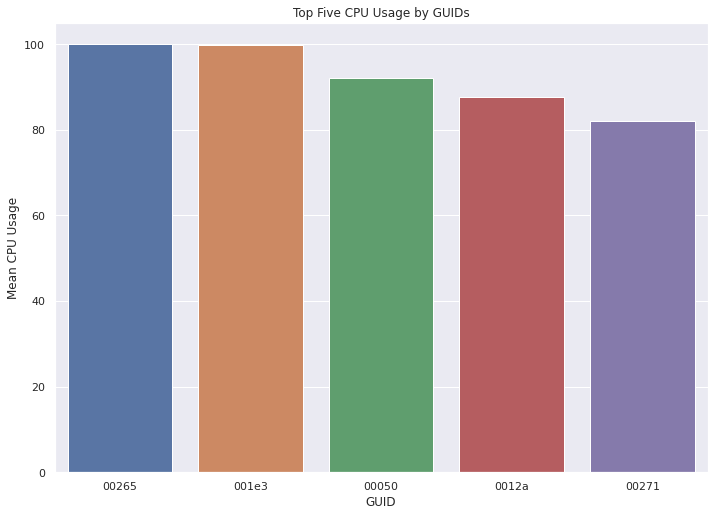

In [97]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="guid", y="mean", data=top5avgcpu)
plt.xlabel('GUID')
plt.ylabel('Mean CPU Usage')
plt.title('Top Five CPU Usage by GUIDs')
plt.show()

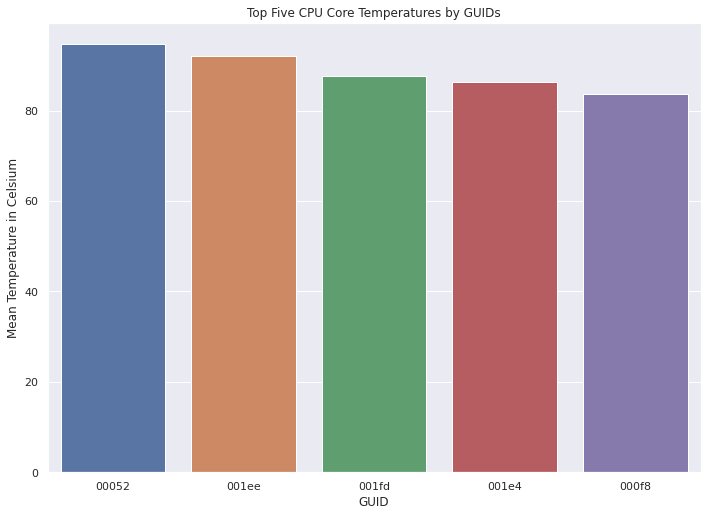

In [121]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="guid", y="mean", data=top5avgtemp)
plt.xlabel('GUID')
plt.ylabel('Mean Temperature in Celsium')
plt.title('Top Five CPU Core Temperatures by GUIDs')
plt.show()

In [57]:
top5avgcpu

,guid,mean
0,002654d93a6945baa5a23f43822a5ede,100.000000
1,001e379a522a4a5da350cb1337ee4d4f,99.833679
2,0005065822f74e3c9fc6e314518111d2,91.989319
3,0012aaaf0c5c4190bdb21b33ceedfe33,87.756157
4,00271175099a4267a9b1042016802bea,82.152199


In [123]:
top5avgtemp

,guid,mean
0,0005263d2afd45e1bbe73f05a4f6586e,94.688530
1,001eee276a5941d29847667d94ab9e84,92.124908
2,001fd895a25449eb8532a806d7ca6aa4,87.656441
3,001e42dbe9384c39a53eb556146f9570,86.282570
4,000f8d68acec461e916d9e07c540a577,83.661667


In [120]:
pd.DataFrame(df['guid'].value_counts())

,guid
000b3f93314b4ee58401005f477c0a68,33063
000c88f421b04c588766b4e9ed016a7c,17097
00032b27f6b047efbd407232b7164ed5,14152
00305ecb779e42fc83622ce93b635489,12402
0007fdb7c39c45a89828e7dc37fc13e8,11492
...,...
0017dce1de69493593dea9c25ecf026d,16
001f0a174f5a4b93a77800a9e9ebb1a5,16
0019cf3e2b614e078744331af6411ad7,11
001696d9b63443c590745a8baf11ce1d,10


## EDA For system_sysinfo_unique_normalized

In [18]:
sys = pd.read_csv('../data/raw/system_sysinfo_unique_normalized.csv000', sep=chr(1))

In [19]:
sys_guid = list(sys['guid'].value_counts().index)
hw_guid = list(df['guid'].value_counts().index)
#dev_guid = list(dev['guid'].value_counts().index)

In [20]:
syshw_overlap = [x for x in sys_guid if x in hw_guid]
len(syshw_overlap)

15428

In [21]:
sys

,load_ts,guid,chassistype,chassistype_2in1_category,countryname,countryname_normalized,modelvendor,modelvendor_normalized,model,model_normalized,...,cpu_suffix,screensize_category,persona,processor_line,vpro_enabled,firstreportdate,lastreportdate,discretegraphics,cpu_stepping,engagement_id
0,2020-10-01 00:48:15,10351643a4ae4b2d9cbc8a90db184050,Notebook,Unknown,Brazil,Brazil,Lenovo,Lenovo,Lenovo G480,Lenovo G480,...,Core-M,14x,Web User,M-Processor,N,2020-01-12 20:31:03,2020-09-29 18:30:56,N,Intel64 Family 6 Model 42 Stepping 7,iduu
1,2020-10-01 00:48:15,4f40b2f38cd74f6ea1559cebbc924619,Notebook,Unknown,Sweden,Sweden,Asus,Asus,T300CHI,T300CHI,...,Core-Y,12x,Web User,Unknown,N,2018-11-15 17:24:52,2020-09-28 12:49:29,N,Intel64 Family 6 Model 61 Stepping 4,iduu
2,2020-10-01 00:48:15,04b81eb4d661410ebff356f27fc544ed,Desktop,Unknown,Viet Nam,Viet Nam,System manufacturer,System manufacturer,System Product Name,System Product Name,...,Other,23x,Office/Productivity,Unknown,Y,2020-05-09 12:24:37,2020-09-29 08:54:35,Y,Intel64 Family 6 Model 158 Stepping 12,intel.com
3,2020-10-01 00:48:15,afd55a587fe14fc1904d572b3230dd54,Notebook,Unknown,Mexico,Mexico,HP,HP,HP ProBook 640 G2,HP ProBook 640 G2,...,Core-U,14x,Office/Productivity,U-Processor,N,2019-10-22 13:56:27,2020-09-28 08:41:47,N,Intel64 Family 6 Model 78 Stepping 3,intel.com
4,2020-10-01 00:48:15,4b3d6747c5f541949f4c1bd127b00bd9,Notebook,Unknown,Romania,Romania,Acer,Acer,Nitro AN515-52,Nitro AN515-52,...,Core-H,15x,Web User,H-Processor,N,2020-04-01 17:37:46,2020-04-23 19:34:16,Y,Intel64 Family 6 Model 158 Stepping 10,intel.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-10-01 00:48:15,018ea22dc279417da3fc7f9d97133d8d,Desktop,Unknown,South Africa,South Africa,Gigabyte,Gigabyte,Q370M D3H GSM PLUS,Q370M D3H GSM PLUS,...,Core-No suffix,<21x,Web User,S-Processor,N,2020-03-10 15:11:12,2020-09-29 08:02:06,N,Intel64 Family 6 Model 158 Stepping 10,iduu
99996,2020-10-01 00:48:15,0139999e8adb4ac1af0f1c4b3dde0e18,Desktop,Unknown,Netherlands,Netherlands,System manufacturer,System manufacturer,System Product Name,System Product Name,...,Pentium/Celeron,<21x,Web User,S-Series,N,2020-01-07 11:41:26,2020-09-29 11:04:44,N,Intel64 Family 6 Model 23 Stepping 10,iduu
99997,2020-10-01 00:48:15,011b2445bf9c47b1a2c834d17cb0969e,2 in 1,Convertible,United States of America,United States of America,Lenovo,Lenovo,Lenovo ideapad FLEX 4-1580,Lenovo ideapad FLEX 4-1580,...,Core-U,15x,Web User,U-Processor,N,2019-09-25 07:55:18,2020-04-14 11:16:59,Y,Intel64 Family 6 Model 142 Stepping 9,iduu
99998,2020-10-01 00:48:15,001fa21540224cc49e73a78f3c7b5800,Desktop,Unknown,Malaysia,Malaysia,Acer,Acer,Nitro N50-600,Nitro N50-600,...,Other,21x,Casual Gamer,Unknown,N,2019-11-29 15:46:07,2020-09-29 21:59:46,Y,Intel64 Family 6 Model 158 Stepping 10,iduu


In [22]:
sys['persona'].value_counts()

Web User                 35153
Casual User              12810
Gamer                    10611
Casual Gamer             10498
Office/Productivity       7519
Content Creator/IT        5883
Communication             5836
Win Store App User        4968
Entertainment             3768
File & Network Sharer     2231
Unknown                    723
Name: persona, dtype: int64

In [23]:
df.head()

,load_ts,batch_id,guid,name,instance,nrs,mean,histogram_min,histogram_max,metric_max_val
0,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW:::GT_C0_RESIDENCY::,1,4862,12.32,0.0,100.0,100.000
1,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,1,4880,33.06,0.0,100.0,91.295
2,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,2,4881,31.71,0.0,100.0,98.921
3,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,3,4880,25.43,0.0,100.0,90.421
4,2020-03-18 04:14:43,20200317-210516,0009a89f8ffa497bb8d27f9df4f44f8c,HW::CORE:C0:PERCENT:,4,4880,20.92,0.0,100.0,88.480


In [24]:
hwcpu_match = cpu.loc[cpu['guid'].isin(syshw_overlap)]
hwcpu_match = hwcpu_match[['guid', 'load_ts', 'mean']]
hwcpu_match['utilization_mean'] = hwcpu_match['mean']
hwcpu_match = hwcpu_match.drop(columns='mean')
hwcpu_match

,guid,load_ts,utilization_mean
1,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,33.060001
2,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,31.709999
3,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,25.430000
4,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,20.920000
5,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,24.430000
...,...,...,...
40230069,015979185e384734b712892cc8dbb1fc,2019-12-12 04:09:22,39.619999
40230070,015979185e384734b712892cc8dbb1fc,2019-12-12 04:09:22,40.180000
40230075,015979185e384734b712892cc8dbb1fc,2019-12-14 04:10:09,42.150002
40230076,015979185e384734b712892cc8dbb1fc,2019-12-14 04:10:09,41.730000


In [25]:
hwtemp_match = temp.loc[temp['guid'].isin(syshw_overlap)]
hwtemp_match = hwtemp_match[['guid', 'load_ts', 'mean']]
hwtemp_match['temp_mean'] = hwtemp_match['mean']
hwtemp_match = hwtemp_match.drop(columns='mean')
hwtemp_match

,guid,load_ts,temp_mean
13,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,51.049999
14,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,50.240002
15,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,49.240002
16,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,49.049999
17,0009a89f8ffa497bb8d27f9df4f44f8c,2020-03-18 04:14:43,49.549999
...,...,...,...
40230068,015979185e384734b712892cc8dbb1fc,2019-12-12 04:09:22,60.290001
40230073,015979185e384734b712892cc8dbb1fc,2019-12-12 04:09:22,53.310001
40230074,015979185e384734b712892cc8dbb1fc,2019-12-12 04:09:22,53.700001
40230079,015979185e384734b712892cc8dbb1fc,2019-12-14 04:10:09,60.330002


In [26]:
hwtemp = pd.DataFrame(hwtemp_match.groupby('guid')['temp_mean'].mean())

In [27]:
hwcpu = pd.DataFrame(hwcpu_match.groupby('guid')['utilization_mean'].mean())

In [28]:
hwtemp

,temp_mean
guid,
00000dd705d7412bbeb716dbf307cbd5,43.896736
00000e9dc2d147079b1c27f34af3c9f7,42.108471
000014861c7148f0ad23307a0f38e868,34.408592
00001551e16943a6b157c51db598b7db,60.656178
000016e78ec946c6ac36cbb394ccc742,42.200603
...,...
62ed83c8699a4fd78be941dd00e4f955,43.927761
63198ac844c94251b41cd2650a797603,37.864025
646f804d0f234f0ba97b3f806f777829,41.991459


In [29]:
hwcpu

,utilization_mean
guid,
00000dd705d7412bbeb716dbf307cbd5,37.820156
00000e9dc2d147079b1c27f34af3c9f7,32.488453
000014861c7148f0ad23307a0f38e868,34.505203
00001551e16943a6b157c51db598b7db,43.759846
000016e78ec946c6ac36cbb394ccc742,13.673221
...,...
62ed83c8699a4fd78be941dd00e4f955,31.615091
63198ac844c94251b41cd2650a797603,43.199356
646f804d0f234f0ba97b3f806f777829,31.597366


In [30]:
#combined_sys['temp_mean']=combined_sys['temp_mean'].fillna(hwtemp.index.to_series())

In [31]:
combined = sys.join(hwcpu, on=['guid'], how='left')
combined

,load_ts,guid,chassistype,chassistype_2in1_category,countryname,countryname_normalized,modelvendor,modelvendor_normalized,model,model_normalized,...,screensize_category,persona,processor_line,vpro_enabled,firstreportdate,lastreportdate,discretegraphics,cpu_stepping,engagement_id,utilization_mean
0,2020-10-01 00:48:15,10351643a4ae4b2d9cbc8a90db184050,Notebook,Unknown,Brazil,Brazil,Lenovo,Lenovo,Lenovo G480,Lenovo G480,...,14x,Web User,M-Processor,N,2020-01-12 20:31:03,2020-09-29 18:30:56,N,Intel64 Family 6 Model 42 Stepping 7,iduu,NaN
1,2020-10-01 00:48:15,4f40b2f38cd74f6ea1559cebbc924619,Notebook,Unknown,Sweden,Sweden,Asus,Asus,T300CHI,T300CHI,...,12x,Web User,Unknown,N,2018-11-15 17:24:52,2020-09-28 12:49:29,N,Intel64 Family 6 Model 61 Stepping 4,iduu,NaN
2,2020-10-01 00:48:15,04b81eb4d661410ebff356f27fc544ed,Desktop,Unknown,Viet Nam,Viet Nam,System manufacturer,System manufacturer,System Product Name,System Product Name,...,23x,Office/Productivity,Unknown,Y,2020-05-09 12:24:37,2020-09-29 08:54:35,Y,Intel64 Family 6 Model 158 Stepping 12,intel.com,NaN
3,2020-10-01 00:48:15,afd55a587fe14fc1904d572b3230dd54,Notebook,Unknown,Mexico,Mexico,HP,HP,HP ProBook 640 G2,HP ProBook 640 G2,...,14x,Office/Productivity,U-Processor,N,2019-10-22 13:56:27,2020-09-28 08:41:47,N,Intel64 Family 6 Model 78 Stepping 3,intel.com,NaN
4,2020-10-01 00:48:15,4b3d6747c5f541949f4c1bd127b00bd9,Notebook,Unknown,Romania,Romania,Acer,Acer,Nitro AN515-52,Nitro AN515-52,...,15x,Web User,H-Processor,N,2020-04-01 17:37:46,2020-04-23 19:34:16,Y,Intel64 Family 6 Model 158 Stepping 10,intel.com,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-10-01 00:48:15,018ea22dc279417da3fc7f9d97133d8d,Desktop,Unknown,South Africa,South Africa,Gigabyte,Gigabyte,Q370M D3H GSM PLUS,Q370M D3H GSM PLUS,...,<21x,Web User,S-Processor,N,2020-03-10 15:11:12,2020-09-29 08:02:06,N,Intel64 Family 6 Model 158 Stepping 10,iduu,NaN
99996,2020-10-01 00:48:15,0139999e8adb4ac1af0f1c4b3dde0e18,Desktop,Unknown,Netherlands,Netherlands,System manufacturer,System manufacturer,System Product Name,System Product Name,...,<21x,Web User,S-Series,N,2020-01-07 11:41:26,2020-09-29 11:04:44,N,Intel64 Family 6 Model 23 Stepping 10,iduu,NaN
99997,2020-10-01 00:48:15,011b2445bf9c47b1a2c834d17cb0969e,2 in 1,Convertible,United States of America,United States of America,Lenovo,Lenovo,Lenovo ideapad FLEX 4-1580,Lenovo ideapad FLEX 4-1580,...,15x,Web User,U-Processor,N,2019-09-25 07:55:18,2020-04-14 11:16:59,Y,Intel64 Family 6 Model 142 Stepping 9,iduu,NaN
99998,2020-10-01 00:48:15,001fa21540224cc49e73a78f3c7b5800,Desktop,Unknown,Malaysia,Malaysia,Acer,Acer,Nitro N50-600,Nitro N50-600,...,21x,Casual Gamer,Unknown,N,2019-11-29 15:46:07,2020-09-29 21:59:46,Y,Intel64 Family 6 Model 158 Stepping 10,iduu,26.996298


In [32]:
combined = combined.join(hwtemp, on=['guid'], how='left')
combined

,load_ts,guid,chassistype,chassistype_2in1_category,countryname,countryname_normalized,modelvendor,modelvendor_normalized,model,model_normalized,...,persona,processor_line,vpro_enabled,firstreportdate,lastreportdate,discretegraphics,cpu_stepping,engagement_id,utilization_mean,temp_mean
0,2020-10-01 00:48:15,10351643a4ae4b2d9cbc8a90db184050,Notebook,Unknown,Brazil,Brazil,Lenovo,Lenovo,Lenovo G480,Lenovo G480,...,Web User,M-Processor,N,2020-01-12 20:31:03,2020-09-29 18:30:56,N,Intel64 Family 6 Model 42 Stepping 7,iduu,NaN,NaN
1,2020-10-01 00:48:15,4f40b2f38cd74f6ea1559cebbc924619,Notebook,Unknown,Sweden,Sweden,Asus,Asus,T300CHI,T300CHI,...,Web User,Unknown,N,2018-11-15 17:24:52,2020-09-28 12:49:29,N,Intel64 Family 6 Model 61 Stepping 4,iduu,NaN,NaN
2,2020-10-01 00:48:15,04b81eb4d661410ebff356f27fc544ed,Desktop,Unknown,Viet Nam,Viet Nam,System manufacturer,System manufacturer,System Product Name,System Product Name,...,Office/Productivity,Unknown,Y,2020-05-09 12:24:37,2020-09-29 08:54:35,Y,Intel64 Family 6 Model 158 Stepping 12,intel.com,NaN,NaN
3,2020-10-01 00:48:15,afd55a587fe14fc1904d572b3230dd54,Notebook,Unknown,Mexico,Mexico,HP,HP,HP ProBook 640 G2,HP ProBook 640 G2,...,Office/Productivity,U-Processor,N,2019-10-22 13:56:27,2020-09-28 08:41:47,N,Intel64 Family 6 Model 78 Stepping 3,intel.com,NaN,NaN
4,2020-10-01 00:48:15,4b3d6747c5f541949f4c1bd127b00bd9,Notebook,Unknown,Romania,Romania,Acer,Acer,Nitro AN515-52,Nitro AN515-52,...,Web User,H-Processor,N,2020-04-01 17:37:46,2020-04-23 19:34:16,Y,Intel64 Family 6 Model 158 Stepping 10,intel.com,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-10-01 00:48:15,018ea22dc279417da3fc7f9d97133d8d,Desktop,Unknown,South Africa,South Africa,Gigabyte,Gigabyte,Q370M D3H GSM PLUS,Q370M D3H GSM PLUS,...,Web User,S-Processor,N,2020-03-10 15:11:12,2020-09-29 08:02:06,N,Intel64 Family 6 Model 158 Stepping 10,iduu,NaN,NaN
99996,2020-10-01 00:48:15,0139999e8adb4ac1af0f1c4b3dde0e18,Desktop,Unknown,Netherlands,Netherlands,System manufacturer,System manufacturer,System Product Name,System Product Name,...,Web User,S-Series,N,2020-01-07 11:41:26,2020-09-29 11:04:44,N,Intel64 Family 6 Model 23 Stepping 10,iduu,NaN,NaN
99997,2020-10-01 00:48:15,011b2445bf9c47b1a2c834d17cb0969e,2 in 1,Convertible,United States of America,United States of America,Lenovo,Lenovo,Lenovo ideapad FLEX 4-1580,Lenovo ideapad FLEX 4-1580,...,Web User,U-Processor,N,2019-09-25 07:55:18,2020-04-14 11:16:59,Y,Intel64 Family 6 Model 142 Stepping 9,iduu,NaN,NaN
99998,2020-10-01 00:48:15,001fa21540224cc49e73a78f3c7b5800,Desktop,Unknown,Malaysia,Malaysia,Acer,Acer,Nitro N50-600,Nitro N50-600,...,Casual Gamer,Unknown,N,2019-11-29 15:46:07,2020-09-29 21:59:46,Y,Intel64 Family 6 Model 158 Stepping 10,iduu,26.996298,57.136864


In [33]:
combined['utilization_mean'].value_counts()

28.718559    2
22.834101    2
45.827198    2
56.497890    2
21.106472    2
            ..
15.309462    1
22.618141    1
37.235058    1
22.315933    1
28.000164    1
Name: utilization_mean, Length: 15300, dtype: int64

In [100]:
sys['guid'].nunique()

100000

In [102]:
cpu['guid'].nunique()

15306

In [106]:
print(combined['utilization_mean'].isna().sum())
print(combined['temp_mean'].isna().sum())

84694
85113


In [34]:
combined = combined[['chassistype', 'modelvendor_normalized', 
                      'ram', 
                     'os','#ofcores', 'age_category',
                    'graphicsmanuf', 'gfxcard', 'graphicscardclass',
                     'cpuvendor', 'cpu_family',
                    'discretegraphics', 'vpro_enabled', 'utilization_mean', 
                     'temp_mean','persona',]]

In [38]:
combined.head()

,chassistype,modelvendor_normalized,ram,os,#ofcores,age_category,graphicsmanuf,gfxcard,graphicscardclass,cpuvendor,cpu_family,discretegraphics,vpro_enabled,utilization_mean,temp_mean,persona
0,Notebook,Lenovo,12.0,Win10,2.0,6+ years,Intel,Intel(R) HD Graphics 3000,Low-End Graphics Cards,Intel,Core i3,N,N,NaN,NaN,Web User
1,Notebook,Asus,8.0,Win10,2.0,5-6 years,Intel,Intel(R) HD Graphics 5300,Low-End Graphics Cards,Intel,Core M,N,N,NaN,NaN,Web User
2,Desktop,System manufacturer,8.0,Win10,8.0,0-1 year,Intel,Intel(R) UHD Graphics 630,Low-Midrange Graphics Cards,Intel,Core i7,Y,Y,NaN,NaN,Office/Productivity
3,Notebook,HP,8.0,Win10,2.0,3-4 years,Intel,Intel(R) HD Graphics 520,Low-Midrange Graphics Cards,Intel,Core i5,N,N,NaN,NaN,Office/Productivity
4,Notebook,Acer,16.0,Win10,4.0,1-2 years,Nvidia,NVIDIA GeForce GTX 1050,Mid-Range Graphics Cards,Intel,Core i5,Y,N,NaN,NaN,Web User


In [39]:
combined.dtypes

chassistype                object
modelvendor_normalized     object
ram                       float64
os                         object
#ofcores                  float64
age_category               object
graphicsmanuf              object
gfxcard                    object
graphicscardclass          object
cpuvendor                  object
cpu_family                 object
discretegraphics           object
vpro_enabled               object
utilization_mean          float32
temp_mean                 float32
persona                    object
dtype: object

In [35]:
copy = combined.copy()
copy.head()

,chassistype,modelvendor_normalized,ram,os,#ofcores,age_category,graphicsmanuf,gfxcard,graphicscardclass,cpuvendor,cpu_family,discretegraphics,vpro_enabled,utilization_mean,temp_mean,persona
0,Notebook,Lenovo,12.0,Win10,2.0,6+ years,Intel,Intel(R) HD Graphics 3000,Low-End Graphics Cards,Intel,Core i3,N,N,NaN,NaN,Web User
1,Notebook,Asus,8.0,Win10,2.0,5-6 years,Intel,Intel(R) HD Graphics 5300,Low-End Graphics Cards,Intel,Core M,N,N,NaN,NaN,Web User
2,Desktop,System manufacturer,8.0,Win10,8.0,0-1 year,Intel,Intel(R) UHD Graphics 630,Low-Midrange Graphics Cards,Intel,Core i7,Y,Y,NaN,NaN,Office/Productivity
3,Notebook,HP,8.0,Win10,2.0,3-4 years,Intel,Intel(R) HD Graphics 520,Low-Midrange Graphics Cards,Intel,Core i5,N,N,NaN,NaN,Office/Productivity
4,Notebook,Acer,16.0,Win10,4.0,1-2 years,Nvidia,NVIDIA GeForce GTX 1050,Mid-Range Graphics Cards,Intel,Core i5,Y,N,NaN,NaN,Web User


In [36]:
print(copy['os'].unique())
print(copy['cpu_family'].unique())
print(copy['cpuvendor'].unique())
print(copy['graphicscardclass'].unique())

['Win10' 'Win7' 'Win8.1' 'Win8' nan 'Win Server']
['Core i3' 'Core M' 'Core i7' 'Core i5' 'Core2' 'Core i9' 'Xeon'
 'Pentium/Celeron' 'Other' 'Atom']
['Intel' 'AMD']
['Low-End Graphics Cards' 'Low-Midrange Graphics Cards'
 'Mid-Range Graphics Cards' nan 'High-End Graphics Cards'
 'Office-Class Graphics Cards' 'Not Suited for Games']


In [37]:
copy_cat = copy[['os','cpu_family', 'cpuvendor', 'graphicscardclass']]

In [38]:
dummy = pd.get_dummies(copy_cat)
dummy['persona'] = copy['persona']

In [39]:
dummy

,os_Win Server,os_Win10,os_Win7,os_Win8,os_Win8.1,cpu_family_Atom,cpu_family_Core M,cpu_family_Core i3,cpu_family_Core i5,cpu_family_Core i7,...,cpu_family_Xeon,cpuvendor_AMD,cpuvendor_Intel,graphicscardclass_High-End Graphics Cards,graphicscardclass_Low-End Graphics Cards,graphicscardclass_Low-Midrange Graphics Cards,graphicscardclass_Mid-Range Graphics Cards,graphicscardclass_Not Suited for Games,graphicscardclass_Office-Class Graphics Cards,persona
0,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,Web User
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,Web User
2,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,Office/Productivity
3,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,Office/Productivity
4,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,Web User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,Web User
99996,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Web User
99997,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,Web User
99998,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,Casual Gamer


In [40]:
cleanup_nums = {"persona": {"Web User": 0, "Casual User": 1, 'Gamer':2, 'Casual Gamer': 3, 'Office/Productivity':4,
                           'Content Creator/IT': 5, 'Communication': 6,
                           'Win Store App User': 7, 'Entertainment': 8,
                          'File & Network Sharer':9, 'Unknown': 10}}

In [41]:
encode_persona = combined['persona'].to_frame().replace(cleanup_nums)

In [42]:
encode_persona

,persona
0,0
1,0
2,4
3,4
4,0
...,...
99995,0
99996,0
99997,0
99998,3


In [43]:
dummy['util_mean'] = combined['utilization_mean']
dummy['temp_mean'] = combined['temp_mean']
dummy = dummy.drop(columns=['persona'])
dummy['persona'] = encode_persona['persona']

In [44]:
dummy

,os_Win Server,os_Win10,os_Win7,os_Win8,os_Win8.1,cpu_family_Atom,cpu_family_Core M,cpu_family_Core i3,cpu_family_Core i5,cpu_family_Core i7,...,cpuvendor_Intel,graphicscardclass_High-End Graphics Cards,graphicscardclass_Low-End Graphics Cards,graphicscardclass_Low-Midrange Graphics Cards,graphicscardclass_Mid-Range Graphics Cards,graphicscardclass_Not Suited for Games,graphicscardclass_Office-Class Graphics Cards,util_mean,temp_mean,persona
0,0,1,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,NaN,NaN,0
1,0,1,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,NaN,NaN,0
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,NaN,NaN,4
3,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,NaN,NaN,4
4,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,NaN,NaN,0
99996,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,NaN,NaN,0
99997,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,NaN,NaN,0
99998,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,26.996298,57.136864,3


In [45]:
dummy_nona = dummy.dropna()
dummy_nona

,os_Win Server,os_Win10,os_Win7,os_Win8,os_Win8.1,cpu_family_Atom,cpu_family_Core M,cpu_family_Core i3,cpu_family_Core i5,cpu_family_Core i7,...,cpuvendor_Intel,graphicscardclass_High-End Graphics Cards,graphicscardclass_Low-End Graphics Cards,graphicscardclass_Low-Midrange Graphics Cards,graphicscardclass_Mid-Range Graphics Cards,graphicscardclass_Not Suited for Games,graphicscardclass_Office-Class Graphics Cards,util_mean,temp_mean,persona
31,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,31.591797,59.058079,2
41,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,41.812885,39.290535,3
72,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,23.001764,41.529495,8
107,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,42.331238,54.387505,0
110,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,45.096786,58.178394,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99989,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,45.682999,40.986866,0
99991,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,22.355558,33.600475,0
99992,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,46.185562,41.398640,2
99998,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,26.996298,57.136864,3


In [46]:
nona_test = dummy_nona.copy()

In [47]:
Y = nona_test['persona']
X = nona_test.drop(columns=['persona'])

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [52]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gradient_Boosting"]
        # "Gaussician_Process"]
         #"Decision_Tree"]
# , "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
#          "Naive_Bayes", "QDA", "SGD"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)]
    #GaussianProcessClassifier(1.0 * RBF(1.0))]
    #
   # DecisionTreeClassifier(max_depth=5)]
#     ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
#     RandomForestClassifier(max_depth=5, n_estimators=100),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(n_estimators=100),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
#     SGDClassifier(loss="hinge", penalty="l2")]

In [53]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    scores.append(score)

In [54]:
scores

[0.27486559139784944,
 0.3400537634408602,
 0.3370295698924731,
 0.3172043010752688,
 0.3014112903225806]

In [55]:
show = pd.DataFrame()
show['name'] = names
show['score'] = scores
show

,name,score
0,Nearest_Neighbors,0.274866
1,Linear_SVM,0.340054
2,Polynomial_SVM,0.337030
3,RBF_SVM,0.317204
4,Gradient_Boosting,0.301411


In [1]:
cm = sns.light_palette("green", as_cmap=True)
s = show.style.background_gradient(cmap=cm)

NameError: name 'sns' is not defined

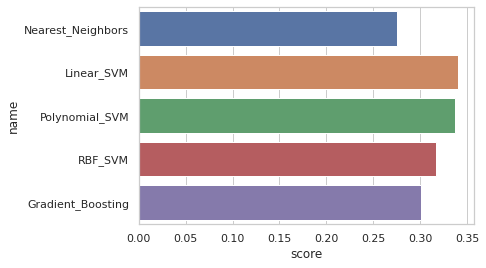

In [58]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=show)

In [30]:
combined['persona'].value_counts()

Web User                 35153
Casual User              12810
Gamer                    10611
Casual Gamer             10498
Office/Productivity       7519
Content Creator/IT        5883
Communication             5836
Win Store App User        4968
Entertainment             3768
File & Network Sharer     2231
Unknown                    723
Name: persona, dtype: int64

In [112]:
combined['model_normalized']

0                       Lenovo G480
1                           T300CHI
2               System Product Name
3                 HP ProBook 640 G2
4                    Nitro AN515-52
                    ...            
99995            Q370M D3H GSM PLUS
99996           System Product Name
99997    Lenovo ideapad FLEX 4-1580
99998                 Nitro N50-600
99999            HP Laptop 15-bs0xx
Name: model_normalized, Length: 100000, dtype: object

In [122]:
print(len(combined['modelvendor_normalized'].value_counts()))
print(len(combined['ram'].value_counts()))

51
99


In [123]:
combined['ram'].value_counts()

8.000000      40270
16.000000     27478
4.000000      14748
32.000000      5661
12.000000      4825
              ...  
120.001953        1
15.000000         1
56.001953         1
200.000000        1
12.000977         1
Name: ram, Length: 99, dtype: int64

In [126]:
combined['gfxcard'].value_counts()[:20]

Intel(R) HD Graphics           7321
Intel(R) HD Graphics 620       6294
Intel(R) HD Graphics 520       6079
Intel(R) UHD Graphics 620      5297
Intel(R) HD Graphics 4600      4898
Intel(R) HD Graphics 4000      4512
Intel(R) HD Graphics 530       3958
Intel(R) HD Graphics Family    3942
Intel(R) HD Graphics 5500      3697
Intel(R) UHD Graphics 630      3094
Intel(R) HD Graphics 630       3034
Intel(R) HD Graphics 3000      2815
NVIDIA GeForce GTX 1050 Ti     1719
NVIDIA GeForce GTX 1050        1553
NVIDIA GeForce GTX 1060 6GB    1280
NVIDIA GeForce GTX 1070        1118
NVIDIA GeForce GTX 960M        1100
NVIDIA GeForce GTX 1080         798
Intel(R) HD Graphics 4400       738
NVIDIA GeForce GTX 970          718
Name: gfxcard, dtype: int64

In [127]:
combined['graphicscardclass'].value_counts()

Low-Midrange Graphics Cards    38542
Low-End Graphics Cards         20363
High-End Graphics Cards        11184
Mid-Range Graphics Cards        9271
Office-Class Graphics Cards     8916
Not Suited for Games             863
Name: graphicscardclass, dtype: int64